In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [37]:
loan_train = pd.read_csv('./data/Train_nyOWmfK_3nIkfd6.csv', index_col='ID')
loan_test = pd.read_csv('./data/Test_bCtAN1w_1.csv', index_col='ID')

In [38]:
%run scripts/helper.py
%run scripts/preprocess.py
%run scripts/models.py
%run scripts/metrics.py
%run scripts/ensembling.py

In [39]:
# columns without any missing values
not_nulls = not_null_cols(loan_train)

In [40]:
# columns with type object that don't have any missing values
obj_cols = cols_with_obj_type(loan_train, not_nulls)

In [41]:
obj_cols

['Gender',
 'DOB',
 'Lead_Creation_Date',
 'Mobile_Verified',
 'Var1',
 'Filled_Form',
 'Device_Type',
 'Var2',
 'Source']

In [42]:
loan_train = loan_train[(loan_train.index != 'ID036559D40')
                        & (loan_train.index != 'ID113457T20')]

In [43]:
loan_train_processed, loan_test_processed = process(loan_train, loan_test, obj_cols)

In [44]:
loan_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87018 entries, ID000002C20 to ID124821V10
Data columns (total 25 columns):
Gender                   87018 non-null int64
City                     86015 non-null object
Monthly_Income           87018 non-null int64
DOB                      87018 non-null object
Lead_Creation_Date       87018 non-null object
Loan_Amount_Applied      86947 non-null float64
Loan_Tenure_Applied      86947 non-null float64
Existing_EMI             86947 non-null float64
Employer_Name            86947 non-null object
Salary_Account           75254 non-null object
Mobile_Verified          87018 non-null int64
Var5                     87018 non-null int64
Var1                     87018 non-null int64
Loan_Amount_Submitted    52405 non-null float64
Loan_Tenure_Submitted    52405 non-null float64
Interest_Rate            27724 non-null float64
Processing_Fee           27418 non-null float64
EMI_Loan_Submitted       27724 non-null float64
Filled_Form              87018 

## Exploratory Data Analysis

In [45]:
loan_train.DOB.isnull().any()

False

In [46]:
loan_train.Lead_Creation_Date.isnull().any()

False

In [47]:
cities = loan_train_processed.groupby(['City', 'Disbursed']).size().unstack()

In [48]:
cities.sort(columns=1, ascending=False)

Disbursed,0,1
City,,
Delhi,12257,269
Bengaluru,10645,179
Mumbai,10625,169
Pune,5086,121
Hyderabad,7188,84
Chennai,6849,67
Kolkata,2838,50
Gurgaon,1185,27
Jaipur,1307,24


In [49]:
def to_lower_case(c):
    try:
        if math.isnan(c):
            return c
        else:
            return c.lower()
    except:
        return c
    
loan_train_processed['City'] = loan_train_processed.City.map(to_lower_case)
loan_test_processed['City'] = loan_test_processed.City.map(to_lower_case)

In [50]:
# fill missing values with -1 for City
loan_train_processed.City.fillna('-1', inplace=True)
loan_test_processed.City.fillna('-1', inplace=True)

In [51]:
loan_train_processed['Salary_Account'] = loan_train_processed.Salary_Account.map(to_lower_case)
loan_test_processed['Salary_Account'] = loan_test_processed.Salary_Account.map(to_lower_case)

In [52]:
# fill missing values with -1 for City
loan_train_processed.Salary_Account.fillna('-1', inplace=True)
loan_test_processed.Salary_Account.fillna('-1', inplace=True)

In [53]:
loan_train_processed['Employer_Name'] = loan_train_processed.Employer_Name.map(to_lower_case)
loan_test_processed['Employer_Name'] = loan_test_processed.Employer_Name.map(to_lower_case)

In [54]:
# fill missing values with -1 for Employer's name
loan_train_processed.Employer_Name.fillna('-1', inplace=True)
loan_test_processed.Employer_Name.fillna('-1', inplace=True)

## Data preparation and Cleaning

In [55]:
# encode city names and salary account in train and test
loan_train_processed, loan_test_processed = process(loan_train_processed, loan_test_processed, ['City', 'Salary_Account'])

In [56]:
# encode employer's name in train and tet
loan_train_processed, loan_test_processed = process(loan_train_processed, loan_test_processed, ['Employer_Name'])

In [57]:
# fill missing values for loan_amount_applied and loan_tenure_applied
loan_train_processed.Loan_Amount_Applied.fillna(loan_train_processed.Loan_Amount_Applied.median(), inplace=True)
loan_train_processed.Loan_Tenure_Applied.fillna(loan_train_processed.Loan_Tenure_Applied.median(), inplace=True)

loan_test_processed.Loan_Amount_Applied.fillna(loan_test_processed.Loan_Amount_Applied.median(), inplace=True)
loan_test_processed.Loan_Tenure_Applied.fillna(loan_test_processed.Loan_Tenure_Applied.median(), inplace=True)

In [58]:
# fill missing values for loan_amount_applied and loan_tenure_applied
loan_train_processed.Loan_Amount_Submitted.fillna(loan_train_processed.Loan_Amount_Submitted.median(), inplace=True)
loan_train_processed.Loan_Tenure_Submitted.fillna(loan_train_processed.Loan_Tenure_Submitted.median(), inplace=True)

loan_test_processed.Loan_Amount_Submitted.fillna(loan_test_processed.Loan_Amount_Submitted.median(), inplace=True)
loan_test_processed.Loan_Tenure_Submitted.fillna(loan_test_processed.Loan_Tenure_Submitted.median(), inplace=True)

In [59]:
# normalize the monthly income variable
loan_train_processed['Monthly_Income'] = np.log1p(loan_train_processed.Monthly_Income)
loan_test_processed['Monthly_Income'] = np.log1p(loan_test_processed.Monthly_Income)

In [60]:
# fill missing values for existing emis
loan_train_processed.Existing_EMI.fillna(loan_train_processed.Existing_EMI.median(), inplace=True)
loan_test_processed.Existing_EMI.fillna(loan_test_processed.Existing_EMI.median(), inplace=True)

In [61]:
# normalize loan applied amount
loan_train_processed['Loan_Amount_Applied'] = np.log1p(loan_train_processed.Loan_Amount_Applied)
loan_test_processed['Loan_Amount_Applied'] = np.log1p(loan_test_processed.Loan_Amount_Applied)

In [62]:
# normalize loan applied amount
loan_train_processed['Loan_Amount_Submitted'] = np.log1p(loan_train_processed.Loan_Amount_Submitted)
loan_test_processed['Loan_Amount_Submitted'] = np.log1p(loan_test_processed.Loan_Amount_Submitted)

In [63]:
# convert both DOB and Lead_Creation_Date to timestamp
loan_train_processed['DOB'] = pd.to_datetime(loan_train_processed.DOB)
loan_test_processed['DOB'] = pd.to_datetime(loan_test_processed.DOB)

loan_train_processed['Lead_Creation_Date'] = pd.to_datetime(loan_train_processed.Lead_Creation_Date)
loan_test_processed['Lead_Creation_Date'] = pd.to_datetime(loan_test_processed.Lead_Creation_Date)

In [64]:
# calculate age delta for training data
loan_train_processed['age_delta'] = (loan_train_processed.Lead_Creation_Date - loan_train_processed.DOB)

In [65]:
# calculate age delta for testing data
loan_test_processed['age_delta'] = (loan_test_processed.Lead_Creation_Date - loan_test_processed.DOB)

In [66]:
loan_train_processed.Interest_Rate.fillna(loan_train_processed.Interest_Rate.median(), inplace=True)
loan_test_processed.Interest_Rate.fillna(loan_test_processed.Interest_Rate.median(), inplace=True)

In [67]:
# calculate new feature: age of candidate when applying for loan
def get_age_in_years(age):
    seconds = age / (1e9)
    days = seconds / (24. * 60 * 60)
    years = days / 365.
    return int(years)

loan_train_processed['age_when_applied'] = loan_train_processed.age_delta.apply(get_age_in_years)

In [68]:
loan_test_processed['age_when_applied'] = loan_test_processed.age_delta.apply(get_age_in_years)

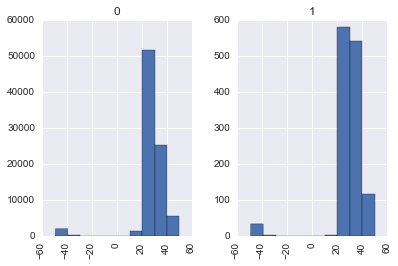

In [69]:
loan_train_processed.hist(column='age_when_applied', by='Disbursed');

In [70]:
loan_train_processed[loan_train_processed.age_when_applied < 0].head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,age_delta,age_when_applied
ID,,,,,,,,,,,,,,,,,,,,,
ID000052A20,1,462,10.933125,2064-05-28,2015-05-01,13.122365,5,14500,51269,22,...,NaN,0,1,4,10,3,0,0,-17925 days,-49
ID000084G40,1,462,10.714440,2050-05-20,2015-05-01,0.000000,0,0,56503,24,...,NaN,0,1,1,10,2,0,0,-12803 days,-35
ID000134E40,0,192,11.928348,2059-10-21,2015-05-01,14.508658,5,37500,6023,3,...,NaN,0,1,1,10,3,0,0,-16244 days,-44
ID000196O10,0,66,10.819798,2061-09-10,2015-05-01,12.206078,2,9507,25371,46,...,NaN,0,1,4,10,3,0,0,-16934 days,-46
ID000201T10,0,478,9.798183,2058-01-29,2015-05-01,0.000000,0,0,32405,54,...,10597.55,1,0,2,10,5,0,0,-15614 days,-42


In [71]:
loan_test_processed[loan_test_processed.age_when_applied < 0].head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,age_delta,age_when_applied
ID,,,,,,,,,,,,,,,,,,,,,
ID000492Y20,1,587,10.933125,2059-06-01,2015-05-01,13.815512,5,13000,7129,25,...,18.0,NaN,NaN,0,1,1,30,3,-16102 days,-44
ID000862E20,1,381,10.085851,2063-03-15,2015-05-01,12.611541,4,0,56098,56,...,20.0,3000,9129.11,1,1,1,20,5,-17485 days,-47
ID001389L40,0,638,11.512935,2053-06-01,2015-05-02,14.220976,5,0,46500,7,...,18.0,NaN,NaN,0,1,1,10,1,-13910 days,-38
ID001458C30,1,249,11.225257,2056-08-11,2015-05-02,13.815512,4,0,36513,58,...,18.0,NaN,NaN,0,1,1,10,3,-15077 days,-41
ID001763V30,1,462,10.434145,2057-08-17,2015-05-02,0.000000,0,0,56116,46,...,15.5,2650,12748.19,1,0,2,10,5,-15448 days,-42


### Model Building

In [72]:
features = loan_train_processed[['City', 'Salary_Account', 'Interest_Rate', 'Employer_Name', 'Monthly_Income', 
                                 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                                 'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                                 'Var1', 'Source', 'Var5', 'age_when_applied']]

In [73]:
from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(loan_train.Disbursed, n_iter=3, test_size=0.3, random_state=121)

In [74]:
train_idx, test_idx = next(iter(sss))

In [75]:
Xt = features.iloc[train_idx]
Xv = features.iloc[test_idx]

yt = loan_train.Disbursed.iloc[train_idx]
yv = loan_train.Disbursed.iloc[test_idx]

In [92]:
# Xgboost classifier
dtrain = xgb.DMatrix(Xt, label=yt)
dval = xgb.DMatrix(Xv[:15000], label=yv[:15000])
dtest = xgb.DMatrix(Xv[15000:])

# Parameters
param = {'bst:max_depth':6, 'bst:eta':.01, 'bst:subsample':.7, 
         'bst:colsample_bytree': 0.8,'silent':1, 'objective':'binary:logistic' }

param['nthread'] = 4
plst = param.items()
plst += [('eval_metric', 'auc')]

# Eval-list to watch performance
evallist  = [(dval,'eval'), (dtrain,'train')]

# Training model
num_round = 1000
bst = xgb.train( plst, dtrain, num_round, evallist )

[0]	eval-auc:0.774362	train-auc:0.774457
[1]	eval-auc:0.806628	train-auc:0.800397
[2]	eval-auc:0.806944	train-auc:0.804597
[3]	eval-auc:0.806741	train-auc:0.803669
[4]	eval-auc:0.810314	train-auc:0.806648
[5]	eval-auc:0.815367	train-auc:0.814618
[6]	eval-auc:0.817023	train-auc:0.817552
[7]	eval-auc:0.816678	train-auc:0.817126
[8]	eval-auc:0.822186	train-auc:0.818425
[9]	eval-auc:0.820328	train-auc:0.818236
[10]	eval-auc:0.820444	train-auc:0.818230
[11]	eval-auc:0.820328	train-auc:0.818381
[12]	eval-auc:0.820119	train-auc:0.818187
[13]	eval-auc:0.820197	train-auc:0.817771
[14]	eval-auc:0.828134	train-auc:0.828084
[15]	eval-auc:0.827765	train-auc:0.828272
[16]	eval-auc:0.827954	train-auc:0.827960
[17]	eval-auc:0.827739	train-auc:0.828602
[18]	eval-auc:0.827863	train-auc:0.829313
[19]	eval-auc:0.828388	train-auc:0.829199
[20]	eval-auc:0.829529	train-auc:0.830694
[21]	eval-auc:0.830376	train-auc:0.832243
[22]	eval-auc:0.830572	train-auc:0.832663
[23]	eval-auc:0.831005	train-auc:0.833365
[2

In [93]:
yv_pred_xgb = bst.predict(dtest)

In [94]:
print 'ROC AUC score on part of test set %f ' %(score(yv[15000:], yv_pred_xgb))

ROC AUC score on part of test set 0.835937 


In [95]:
# Random Forest Classifier
model_rf = random_forest_classifier(Xt, yt)

In [96]:
# Gradient Boosting Classifier
model = gradient_boosting_classifier(Xt, yt)

In [97]:
model_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [98]:
model

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [99]:
yt_pred_rf = predictions(model_rf, Xt)[:, 1]
print 'ROC AUC score on the training set for Random Forest Classifier %f ' %(score(yt, yt_pred_rf))

ROC AUC score on the training set for Random Forest Classifier 0.999999 


In [100]:
yt_pred_gbr = predictions(model, Xt)[:, 1]
print 'ROC AUC score on the training set for GBC %f ' %(score(yt, yt_pred_gbr))

ROC AUC score on the training set for GBC 0.881234 


In [101]:
yt_pred_xgb = bst.predict(dtrain)
print 'ROC AUC score on the training set for XGBoost %f ' %score(yt, yt_pred_xgb)

ROC AUC score on the training set for XGBoost 0.952030 


In [103]:
yt_pred_ensemble = (.1 * yt_pred_rf + .1 * yt_pred_gbr + .8 * yt_pred_xgb)
print 'ROC AUC score on the training set for ensemble %f ' %(score(yt, yt_pred_ensemble))

ROC AUC score on the training set for ensemble 0.995715 


In [1011]:
train_blending_submission = stacked_blending(Xt.values, yt.values, Xv.values)

Creating train and test sets for blending.
0 RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
[30410 30411 30412 ..., 60911 60912 60913]
Fold 1
[    0     1     2 ..., 32409 32448 32451]
1 GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              random_state=None, subsample=0.9, verbose=0,
              warm_start=False)
Fold 0
[30410 30411 30412 ..., 60911 60912 60913]
Fold 1
[    0     1     2 ..., 32409 32448 32451]

Blending.
Linear stretch of predictions to 

In [1012]:
print 'ROC score %f ' %(score(yv, train_blending_submission))

ROC score 0.832172 


### Validation set

In [104]:
yv_pred_rf = predictions(model_rf, Xv)[:, 1]
print 'ROC AUC score on the test set for Random Forest Classifier %f ' %(score(yv, yv_pred_rf))

ROC AUC score on the test set for Random Forest Classifier 0.814748 


In [106]:
yv_pred_gbr = predictions(model, Xv)[:, 1]
print 'ROC AUC score on the test set for GBC %f ' %(score(yv, yv_pred_gbr))

ROC AUC score on the test set for GBC 0.847879 


In [107]:
dv = xgb.DMatrix(Xv)
yv_pred_xgb = bst.predict(dv)

In [113]:
yv_pred_ensemble = (.1 * yv_pred_rf + .1 * yv_pred_gbr + .8 * yv_pred_xgb)
print 'ROC AUC score on the test set for ensemble %f ' %(score(yv, yv_pred_ensemble))

ROC AUC score on the test set for ensemble 0.850916 


### Final Model

In [124]:
features_test = loan_test[['City', 'Salary_Account', 'Interest_Rate', 'Employer_Name', 'Monthly_Income', 
                         'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                         'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                         'Var1', 'Source', 'Var5', 'age_when_applied']]

In [115]:
# Train Rf and GBR models on full data
model_final_rf = random_forest_classifier(features, loan_train_processed.Disbursed)
model_final_gbr = gradient_boosting_classifier(features, loan_train_processed.Disbursed)

In [116]:
total_data = xgb.DMatrix(features, label=loan_train_processed.Disbursed)
model_final_xgb = xgb.train( plst, total_data, num_round )

In [117]:
total_test_data = xgb.DMatrix(features_test)

In [118]:
final_preds_xgb = model_final_xgb.predict(total_test_data)

In [125]:
final_preds_rf = predictions(model_final_rf, features_test)[:, 1]
final_preds_gbr = predictions(model_final_gbr, features_test)[:, 1]

In [126]:
final_preds = (.1 * final_preds_rf + .1 * final_preds_gbr + .9 * final_preds_xgb)

In [127]:
create_submission_file(loan_test.index.values, final_preds, 'ensemble_rf_gbc_xgb_removed_rows.csv')

## Feature Selection

In [108]:
%run scripts/feature_selection.py

In [109]:
feature_selection(loan_train_processed[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income','Var5', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']], 
                  loan_train_processed.Disbursed)

initial f1 score based on extra trees classifier:  0.0
feature importance:  [ 0.09203676  0.08384553  0.11182189  0.11072908  0.04303247  0.05550208
  0.03880343  0.08399025  0.0735262   0.03622075  0.04435319  0.01275061
  0.00250464  0.02240173  0.04466838  0.04152769  0.10228534]
sorted feature importances:  [ 0.11182189  0.11072908  0.10228534  0.09203676  0.08399025  0.08384553
  0.0735262   0.05550208  0.04466838  0.04435319  0.04303247  0.04152769
  0.03880343  0.03622075  0.02240173  0.01275061  0.00250464]
output format:
no of features, f1-score, roc-score of class-predictions, roc-score of probabilities
1 0.00481927710843 0.500686913274 0.564706467202
2 0.00497512437811 0.500939595594 0.809889017203
3 0.00502512562814 0.501017344 0.809101102236
4 0.01 0.502306807422 0.812684448935
5 0.0102301790281 0.502481741336 0.81692275472
6 0.00516795865633 0.501231152117 0.823756982092
7 0.0 0.499727880578 0.826796089947
8 0.0 0.499825066086 0.828271528778
9 0.0 0.49974731768 0.83190295

## Unsupervised Learning

In [39]:
non_disbursed_examples = loan_train_processed[loan_train_processed.Disbursed == 0]

In [40]:
non_disbursed_features = non_disbursed_examples[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']]

In [41]:
from sklearn.cluster import KMeans

In [42]:
kmeans = KMeans(n_clusters=4, n_init=10, n_jobs=-1)
kmeans.fit(non_disbursed_features)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [44]:
labels = kmeans.predict(non_disbursed_features)

In [46]:
non_disbursed_features.loc[:,'labels'] = labels

/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
non_disbursed_features.columns

Index([u'City', u'Salary_Account', u'Employer_Name', u'Monthly_Income', u'Loan_Amount_Applied', u'Loan_Tenure_Applied', u'Existing_EMI', u'Loan_Amount_Submitted', u'Loan_Tenure_Submitted', u'Var1', u'Filled_Form', u'Device_Type', u'Var2', u'Source', u'Var5', u'age_when_applied', u'labels'], dtype='object')

In [49]:
from collections import Counter

In [50]:
Counter(labels)

Counter({0: 47368, 2: 38377, 1: 1, 3: 1})

In [51]:
non_disbursed_features[(non_disbursed_features['labels'] == 1)|
                       (non_disbursed_features['labels'] == 3)]

,City,Salary_Account,Employer_Name,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Loan_Amount_Submitted,Loan_Tenure_Submitted,Var1,Filled_Form,Device_Type,Var2,Source,Var5,age_when_applied,labels
ID,,,,,,,,,,,,,,,,,
ID036559D40,177,46,301,18.603836,13.122365,0,5454365,13.122365,5,12,0,1,1,24,15,40,1
ID113457T20,462,22,23661,17.341871,13.815512,5,10000000,13.815512,5,8,0,1,6,0,13,45,3


In [60]:
loan_train.ix['ID113457T20']

Gender                                     1
City                                     462
Monthly_Income                      17.34187
DOB                      1970-01-01 00:00:00
Lead_Creation_Date       2015-07-24 00:00:00
Loan_Amount_Applied                 13.81551
Loan_Tenure_Applied                        5
Existing_EMI                           1e+07
Employer_Name                          23661
Salary_Account                            22
Mobile_Verified                            1
Var5                                      13
Var1                                       8
Loan_Amount_Submitted               13.81551
Loan_Tenure_Submitted                      5
Interest_Rate                          13.99
Processing_Fee                          5000
EMI_Loan_Submitted                  23263.07
Filled_Form                                0
Device_Type                                1
Var2                                       6
Source                                     0
Var4      

In [62]:
loan_train_processed.ix['ID036559D40']

Gender                                     1
City                                     177
Monthly_Income                      18.60384
DOB                      1975-03-13 00:00:00
Lead_Creation_Date       2015-05-29 00:00:00
Loan_Amount_Applied                 13.12237
Loan_Tenure_Applied                        0
Existing_EMI                         5454365
Employer_Name                            301
Salary_Account                            46
Mobile_Verified                            1
Var5                                      15
Var1                                      12
Loan_Amount_Submitted               13.12237
Loan_Tenure_Submitted                      5
Interest_Rate                           15.5
Processing_Fee                          5000
EMI_Loan_Submitted                   12026.6
Filled_Form                                0
Device_Type                                1
Var2                                       1
Source                                    24
Var4      

** In both the cases existing EMI is too high, might be the case that this might be not be recorded properly. **

In [81]:
non_disbursed_features_0 = non_disbursed_features[non_disbursed_features['labels'] == 0]
non_disbursed_features_0 = non_disbursed_features_0[non_disbursed_features_0.columns.drop('labels')]

non_disbursed_features_2 = non_disbursed_features[non_disbursed_features['labels'] == 2]
non_disbursed_features_2 = non_disbursed_features_2[non_disbursed_features_2.columns.drop('labels')]

In [82]:
disbursed_examples = loan_train_processed[loan_train_processed.Disbursed == 1]
disbursed_features = disbursed_examples[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']]

In [83]:
dataset_0 = np.concatenate((non_disbursed_features_0.values, disbursed_features.values), axis=0)

In [85]:
dataset_2 = np.concatenate((non_disbursed_features_2.values, disbursed_features.values), axis=0)

In [86]:
labels_0 = np.concatenate(([0.] * non_disbursed_features_0.shape[0], [1.] * disbursed_features.shape[0]))

In [89]:
labels_2 = np.concatenate(([0.] * non_disbursed_features_2.shape[0], [1.] * disbursed_features.shape[0]))

In [91]:
from sklearn.cross_validation import train_test_split

In [92]:
dataset_0_train, dataset_0_test, y_0_t, y_0_v = train_test_split(dataset_0, labels_0, 
                                                                 test_size=0.3, random_state=9)

In [93]:
gbr_est = gradient_boosting_classifier(dataset_0_train, y_0_t)

In [95]:
gbr_pred_t = gbr_est.predict_proba(dataset_0_train)[:, 1]
print 'ROC AUC score on training set %f ' %(score(y_0_t, gbr_pred_t))

ROC AUC score on training set 0.940745 


In [96]:
gbr_pred_v = gbr_est.predict_proba(dataset_0_test)[:, 1]
print 'ROC AUC score on test set %f' %(score(y_0_v, gbr_pred_v))

ROC AUC score on test set 0.906247


In [97]:
dataset_2_train, dataset_2_test, y_2_t, y_2_v = train_test_split(dataset_2, labels_2, 
                                                                 test_size=0.3, random_state=9)

In [98]:
gbr_est_2 = gradient_boosting_classifier(dataset_2_train, y_2_t)

In [99]:
gbr_pred_t_2 = gbr_est_2.predict_proba(dataset_2_train)[:, 1]
print 'ROC AUC score on training set %f ' %(score(y_2_t, gbr_pred_t_2))

ROC AUC score on training set 0.952114 


In [100]:
gbr_pred_v_2 = gbr_est_2.predict_proba(dataset_2_test)[:, 1]
print 'ROC AUC score on test set %f' %(score(y_2_v, gbr_pred_v_2))

ROC AUC score on test set 0.920762


In [140]:
first_test_set = dataset_0_test[:6000]
second_test_set = dataset_2_test[:6000]

In [141]:
unseen = np.concatenate((first_test_set, second_test_set), axis=0)

In [142]:
labels_first = y_0_v[:6000]
labels_second = y_2_v[:6000]

unseen_labels = np.hstack((labels_first, labels_second))

In [143]:
unseen_pred_0 = gbr_est.predict_proba(unseen)[:, 1]
unseen_pred_2 = gbr_est_2.predict_proba(unseen)[:, 1]
unseen_ensemble = .5 * unseen_pred_0 + .5 * unseen_pred_2
print 'ROC AUC score on cluster 2 examples %f ' %(score(unseen_labels, unseen_ensemble))

ROC AUC score on cluster 2 examples 0.849828 


In [145]:
# Training on full dataset 
gbr_cluster_0_est = gradient_boosting_classifier(dataset_0, labels_0)
gbr_cluster_2_est = gradient_boosting_classifier(dataset_2, labels_2)

In [152]:
# Predictions
gbr_cluster_0_pred = predictions(gbr_cluster_0_est, features_test)[:, 1]
gbr_cluster_2_pred = predictions(gbr_cluster_2_est, features_test)[:, 1]

In [153]:
gbr_final_preds_ensemble = 0.5 * gbr_cluster_0_pred + 0.5 * gbr_cluster_2_pred

In [154]:
create_submission_file(loan_test.index.values, gbr_final_preds_ensemble, 
                       'ensemble_gbr_clusters.csv')